In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.nn import functional as F

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

import os

import nltk
nltk.download('words')
import random

from nltk.corpus import words

torch.set_default_tensor_type(torch.cuda.FloatTensor)

# English Dictionary of words converted to byte representations
byteWords = np.array([bytearray(w.ljust(16, '\0'),'utf-8')[:16] for w in words.words()])


[nltk_data] Downloading package words to
[nltk_data]     /home/isaacwestlund/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False).cuda()
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))]).cuda()
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))]).cuda()
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z).cuda() + logp.cuda()
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [5]:
nets = lambda: nn.Sequential(nn.Linear(16, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 16), nn.Tanh()).cuda()
nett = lambda: nn.Sequential(nn.Linear(16, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 16)).cuda()
masks = torch.from_numpy(np.array([[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0]] * 3).astype(np.float32)).cuda()
prior = distributions.MultivariateNormal(torch.zeros(16), torch.eye(16))
flow = RealNVP(nets, nett, masks, prior).cuda()

In [7]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)

norm_losses = []
for t in range(50001):    
    sample = torch.from_numpy(np.random.randint(255, size=(10000,16)).astype(np.float32)).cuda()
    loss = -flow.log_prob(sample).mean()
#     noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
#     loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        norm_losses.append(loss.data.cpu())
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2124704.000
iter 500: loss = 1558.576
iter 1000: loss = 668.109
iter 1500: loss = 596.613
iter 2000: loss = 246.355
iter 2500: loss = 216.208
iter 3000: loss = 197.607
iter 3500: loss = 187.871
iter 4000: loss = 181.960
iter 4500: loss = 179.614
iter 5000: loss = 177.039
iter 5500: loss = 176.230
iter 6000: loss = 176.070
iter 6500: loss = 174.684
iter 7000: loss = 173.738
iter 7500: loss = 172.969
iter 8000: loss = 172.719
iter 8500: loss = 171.569
iter 9000: loss = 170.944
iter 9500: loss = 169.814
iter 10000: loss = 169.651
iter 10500: loss = 169.109
iter 11000: loss = 168.326
iter 11500: loss = 168.128
iter 12000: loss = 167.870
iter 12500: loss = 167.569
iter 13000: loss = 167.118
iter 13500: loss = 166.441
iter 14000: loss = 165.486
iter 14500: loss = 165.391
iter 15000: loss = 164.358
iter 15500: loss = 163.522
iter 16000: loss = 162.882
iter 16500: loss = 161.715
iter 17000: loss = 161.531
iter 17500: loss = 160.568
iter 18000: loss = 160.298
iter 18500: loss = 1

In [10]:
# Generate data for NIST tests

print(len(norm_losses))
z_test = torch.from_numpy(byteWords.astype(np.float32)).to("cuda")
with torch.no_grad():
#     flow.g.eval()
    x_test = flow.g(z_test).cpu()
#     flow.g.train()
    data = x_test.data.numpy()
    with open('randomOutputNorm.dat', 'wb') as f:
        for i in range(len(data)):
            for j in range(len(data[0])):
                f.write(data[i,j])

101


In [11]:
# GAN loss function pulled from assignment 3
def loss_nonsaturating(g, d, x_real, words_z, *, device):
    '''
    Arguments:
    - g (codebase.network.Generator): The generator network
    - d (codebase.network.Discriminator): The discriminator network
      - Note that d outputs logits
    - x_real (torch.Tensor): training data samples (64, 1, 28, 28)
    - device (torch.device): 'cpu' by default

    Returns:
    - d_loss (torch.Tensor): nonsaturating discriminator loss
    - g_loss (torch.Tensor): nonsaturating generator loss
    '''
    batch_size = x_real.shape[0]
    
    z = word_z

    first = -torch.mean(F.logsigmoid(d(x_real)))

    second = -torch.mean(torch.log(1-torch.sigmoid(d(g(z)))))
    
    d_loss = first + second 

    g_loss = -torch.mean(F.logsigmoid(d(g(z))))

    return d_loss, g_loss

In [12]:
class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.size(0), *self.shape)

class Generator(torch.nn.Module):
    def __init__(self, dim_z=16, num_channels=1):
        super().__init__()
        self.dim_z = dim_z
        nets = lambda: nn.Sequential(nn.Linear(16, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 16), nn.Tanh()).cuda()
        nett = lambda: nn.Sequential(nn.Linear(16, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 16)).cuda()
        masks = torch.from_numpy(np.array([[0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1], [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0]] * 3).astype(np.float32)).cuda()
        prior = distributions.MultivariateNormal(torch.zeros(16), torch.eye(16))
        self.flow = RealNVP(nets, nett, masks, prior).cuda()
        self.net = self.flow.g

    def forward(self, z):
        return self.net(z)

class Discriminator(torch.nn.Module):
    def __init__(self, num_channels=1):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(16, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.LeakyReLU(0.1, inplace=True),
            
            torch.nn.Linear(512, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.LeakyReLU(0.1, inplace=True),
            
            torch.nn.Linear(512, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        return self.net(x)


In [13]:
device = torch.device("cuda")
g = Generator().to("cuda")
d = Discriminator().to("cuda")


batch_size = 1000

out_dir = 'savedModel'
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

g_optimizer = torch.optim.Adam([p for p in g.flow.parameters() if p.requires_grad==True], lr=1e-4)
d_optimizer = torch.optim.Adam(d.parameters(), 1e-3, betas=(0.5, 0.999))

global_step = 0
g_losses = []
d_losses = []
for _ in range(5001):
    x_real = torch.from_numpy(np.random.randint(255, size=(batch_size,16)).astype(np.float32)).to("cuda")
    
    np.random.shuffle(byteWords)
    word_z = torch.from_numpy(byteWords[:batch_size].astype(np.float32)).to("cuda")

    loss = loss_nonsaturating

    d_loss, g_loss = loss(g, d, x_real, word_z, device=device)

    d_optimizer.zero_grad()
    d_loss.backward(retain_graph=True)
    d_optimizer.step()

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    global_step += 1
            
    if global_step % 100 == 0:
        g_losses.append(g_loss.data.cpu())
        d_losses.append(d_loss.data.cpu())
        print('iter %s:' % global_step, 'd_loss = %.3f' % g_loss, 'g_loss = %.3f' % d_loss)

with torch.no_grad():
    torch.save((g, d), '%s/model_%04d.pt' % (out_dir, global_step))

iter 100: d_loss = 0.617 g_loss = 1.363
iter 200: d_loss = 0.661 g_loss = 1.329
iter 300: d_loss = 0.661 g_loss = 1.346
iter 400: d_loss = 0.678 g_loss = 1.332
iter 500: d_loss = 0.700 g_loss = 1.315
iter 600: d_loss = 0.702 g_loss = 1.320
iter 700: d_loss = 0.703 g_loss = 1.314
iter 800: d_loss = 0.712 g_loss = 1.315
iter 900: d_loss = 0.714 g_loss = 1.287
iter 1000: d_loss = 0.696 g_loss = 1.291
iter 1100: d_loss = 0.690 g_loss = 1.309
iter 1200: d_loss = 0.719 g_loss = 1.279
iter 1300: d_loss = 0.717 g_loss = 1.285
iter 1400: d_loss = 0.719 g_loss = 1.301
iter 1500: d_loss = 0.724 g_loss = 1.289
iter 1600: d_loss = 0.719 g_loss = 1.270
iter 1700: d_loss = 0.721 g_loss = 1.254
iter 1800: d_loss = 0.675 g_loss = 1.338
iter 1900: d_loss = 0.729 g_loss = 1.258
iter 2000: d_loss = 0.720 g_loss = 1.257
iter 2100: d_loss = 0.729 g_loss = 1.252
iter 2200: d_loss = 0.719 g_loss = 1.255
iter 2300: d_loss = 0.725 g_loss = 1.255
iter 2400: d_loss = 0.713 g_loss = 1.273
iter 2500: d_loss = 0.735

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RealNVP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [144]:
# Generate data for NIST tests
z_test = torch.from_numpy(byteWords.astype(np.float32)).to("cuda")
with torch.no_grad():
    g.eval()
    x_test = g(z_test).cpu()
    g.train()
    data = x_test.data.numpy()
    with open('randomOutput.dat', 'wb') as f:
        for i in range(len(data)):
            for j in range(len(data[0])):
                f.write(data[i,j])

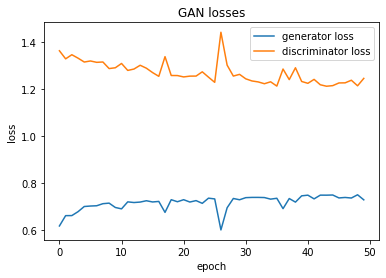

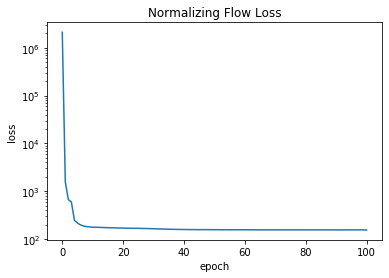

In [27]:
plt.plot(g_losses, label='generator loss')
plt.plot(d_losses, label='discriminator loss')
plt.legend()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("GAN losses")
plt.savefig("ganLoss.png")
plt.show()

plt.plot(norm_losses)
plt.title("Normalizing Flow Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.yscale('log')
plt.savefig("normLoss.png")
plt.show()

